In [20]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
import cv2 as cv
import h5py
import os
import numpy as np
from glob import glob
from tqdm import tqdm
from generate_samples import visualize_syn_data
from warnings import filterwarnings
from syndata import get_exo_locations
from itertools import product
filterwarnings('ignore')

In [23]:
def visualize_data(data,exo_locations):
    _, axes = plt.subplots(nrows=5,ncols=5,figsize=(20,20))

    for i, (row,col) in enumerate(product(range(5),range(5))):
        star_circle = plt.Circle( (70, 90 ),
                                      20 ,
                                      fill =False ,color='red')
        
        exo_circle = plt.Circle( (exo_locations[i][0]+3, exo_locations[i][1]+3),
                                     3 ,
                                     fill = False ,color='blue')
        
        axes[row][col].imshow(data[i],cmap='gray',clim=(0,124))
        axes[row][col].add_artist(star_circle)
        axes[row][col].add_artist(exo_circle)
        axes[row][col].set_yticks([])
        axes[row][col].set_xticks([])
        
    _.patch.set_facecolor('#423f3b')
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()  

In [3]:
class SyntheticDataset(Dataset):
    
    def __init__(self,star:list,exo:list,nothing:list,transform=True):
            
        self.star      = star
        self.exo       = exo
        self.nothing   = nothing
        self.transform = transform 
        self.exo_locs  = exo_locs
        
        self.arr      = np.concatenate((exo[0],star[0],nothing[0]))
        self.label    = torch.vstack((exo[1],star[1],nothing[1]))
        
        self.data = [self.arr,self.label]
        
    def __len__(self):
        
        return self.label.size(0)
    
    def __getitem__(self,idx):
        
        sample = self.data[0][idx]
        label  = self.data[1][idx]
        
        if self.transform:
            sample = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.CenterCrop(160),
                           ])(sample)
            
        
        return [sample,label]

In [4]:
def label_data(arr:np.ndarray,label:str):
    star_label    = torch.Tensor([1,0])
    exo_label     = torch.Tensor([1,1])
    nothing_label = torch.Tensor([0,0])
    
    labelled = []
    
    if label == 'star':
        label_stack = torch.stack((star_label,star_label))
        labelled.append(arr)
            
        for i in range(2,len(arr)):
            label_stack = torch.vstack((label_stack,star_label))
        labelled.append(label_stack)
    
    elif label == 'exo':
        
        label_stack = torch.stack((exo_label,exo_label))
        labelled.append(arr)
        for i in range(2,len(arr)):
            label_stack = torch.vstack((label_stack,exo_label))
        labelled.append(label_stack)
        
    if label == 'nothing':
        
        label_stack = torch.stack((nothing_label,nothing_label))
        labelled.append(arr)
            
        for i in range(2,len(arr)):
            label_stack = torch.vstack((label_stack,nothing_label))
        labelled.append(label_stack)
            
    return labelled

In [5]:
DIR = '/home/sarperyn/sarperyurtseven/ProjectFiles/dataset/'
h5_files = glob(os.path.join(DIR,'NIRCAM/**/*.h5'))
data_1441 = h5py.File(h5_files[0],'r')
data_1386 = h5py.File(h5_files[1],'r')
keys_1386 = [x for x in data_1386.keys()]
final_1386 = np.concatenate((np.array(data_1386[keys_1386[0]]),np.array(data_1386[keys_1386[1]])))

for i in range(len(keys_1386)-2):
    
    final_1386 = np.concatenate((final_1386,np.array(data_1386[keys_1386[i+2]])))

In [6]:
augmented_1386   = np.load(f'{DIR}/augmented/augmented.npy')
augmented_erased = np.load(f'{DIR}/augmented/augmented_erased_data.npy')

In [7]:
exo_f250m = np.concatenate((np.load(f'{DIR}/synthetic/exo1_f250m.npy'),np.load(f'{DIR}/synthetic/exo2_f250m.npy')),axis=0)
exo_f300m = np.concatenate((np.load(f'{DIR}/synthetic/exo1_f300m.npy'),np.load(f'{DIR}/synthetic/exo2_f300m.npy')),axis=0)
exo_f356w = np.concatenate((np.load(f'{DIR}/synthetic/exo1_f356w.npy'),np.load(f'{DIR}/synthetic/exo2_f356w.npy')),axis=0)
exo_f410m = np.concatenate((np.load(f'{DIR}/synthetic/exo1_f410m.npy'),np.load(f'{DIR}/synthetic/exo2_f410m.npy')),axis=0)
exo_f444w = np.concatenate((np.load(f'{DIR}/synthetic/exo1_f444w.npy'),np.load(f'{DIR}/synthetic/exo2_f444w.npy')),axis=0)

In [8]:
star_erased = np.load(f'{DIR}/synthetic/star_erased.npy')

In [9]:
exo     = np.concatenate((exo_f250m,exo_f300m,exo_f356w,exo_f410m,exo_f444w),axis=0)
star    = np.concatenate((final_1386,augmented_1386),axis=0)
nothing = np.concatenate((star_erased,augmented_erased),axis=0) 

In [10]:
exo_locs = get_exo_locations()

In [11]:
display(exo.shape)
display(star.shape)
display(nothing.shape)

(4100, 320, 320)

(4032, 320, 320)

(4032, 320, 320)

In [12]:
star_labelled    = label_data(star,label='star')
exo_labelled     = label_data(exo,label='exo')
nothing_labelled = label_data(nothing,label='nothing')

In [13]:
dataset = SyntheticDataset(star=star_labelled,exo=exo_labelled,nothing=nothing_labelled)

In [14]:
dataloader = DataLoader(dataset,batch_size=25,shuffle=False)

In [15]:
_,diotta = next(enumerate(dataloader))

In [16]:
new_locs = [] 

for x,y in exo_locs:
    x_new, y_new = x-80,y-80
    new_locs.append((x_new,y_new))

In [17]:
img_stack = torch.concat((diotta[0][0],diotta[0][1]))

for i in range(2,25):
    
    img_stack = torch.concat((img_stack,diotta[0][i]),axis=0)


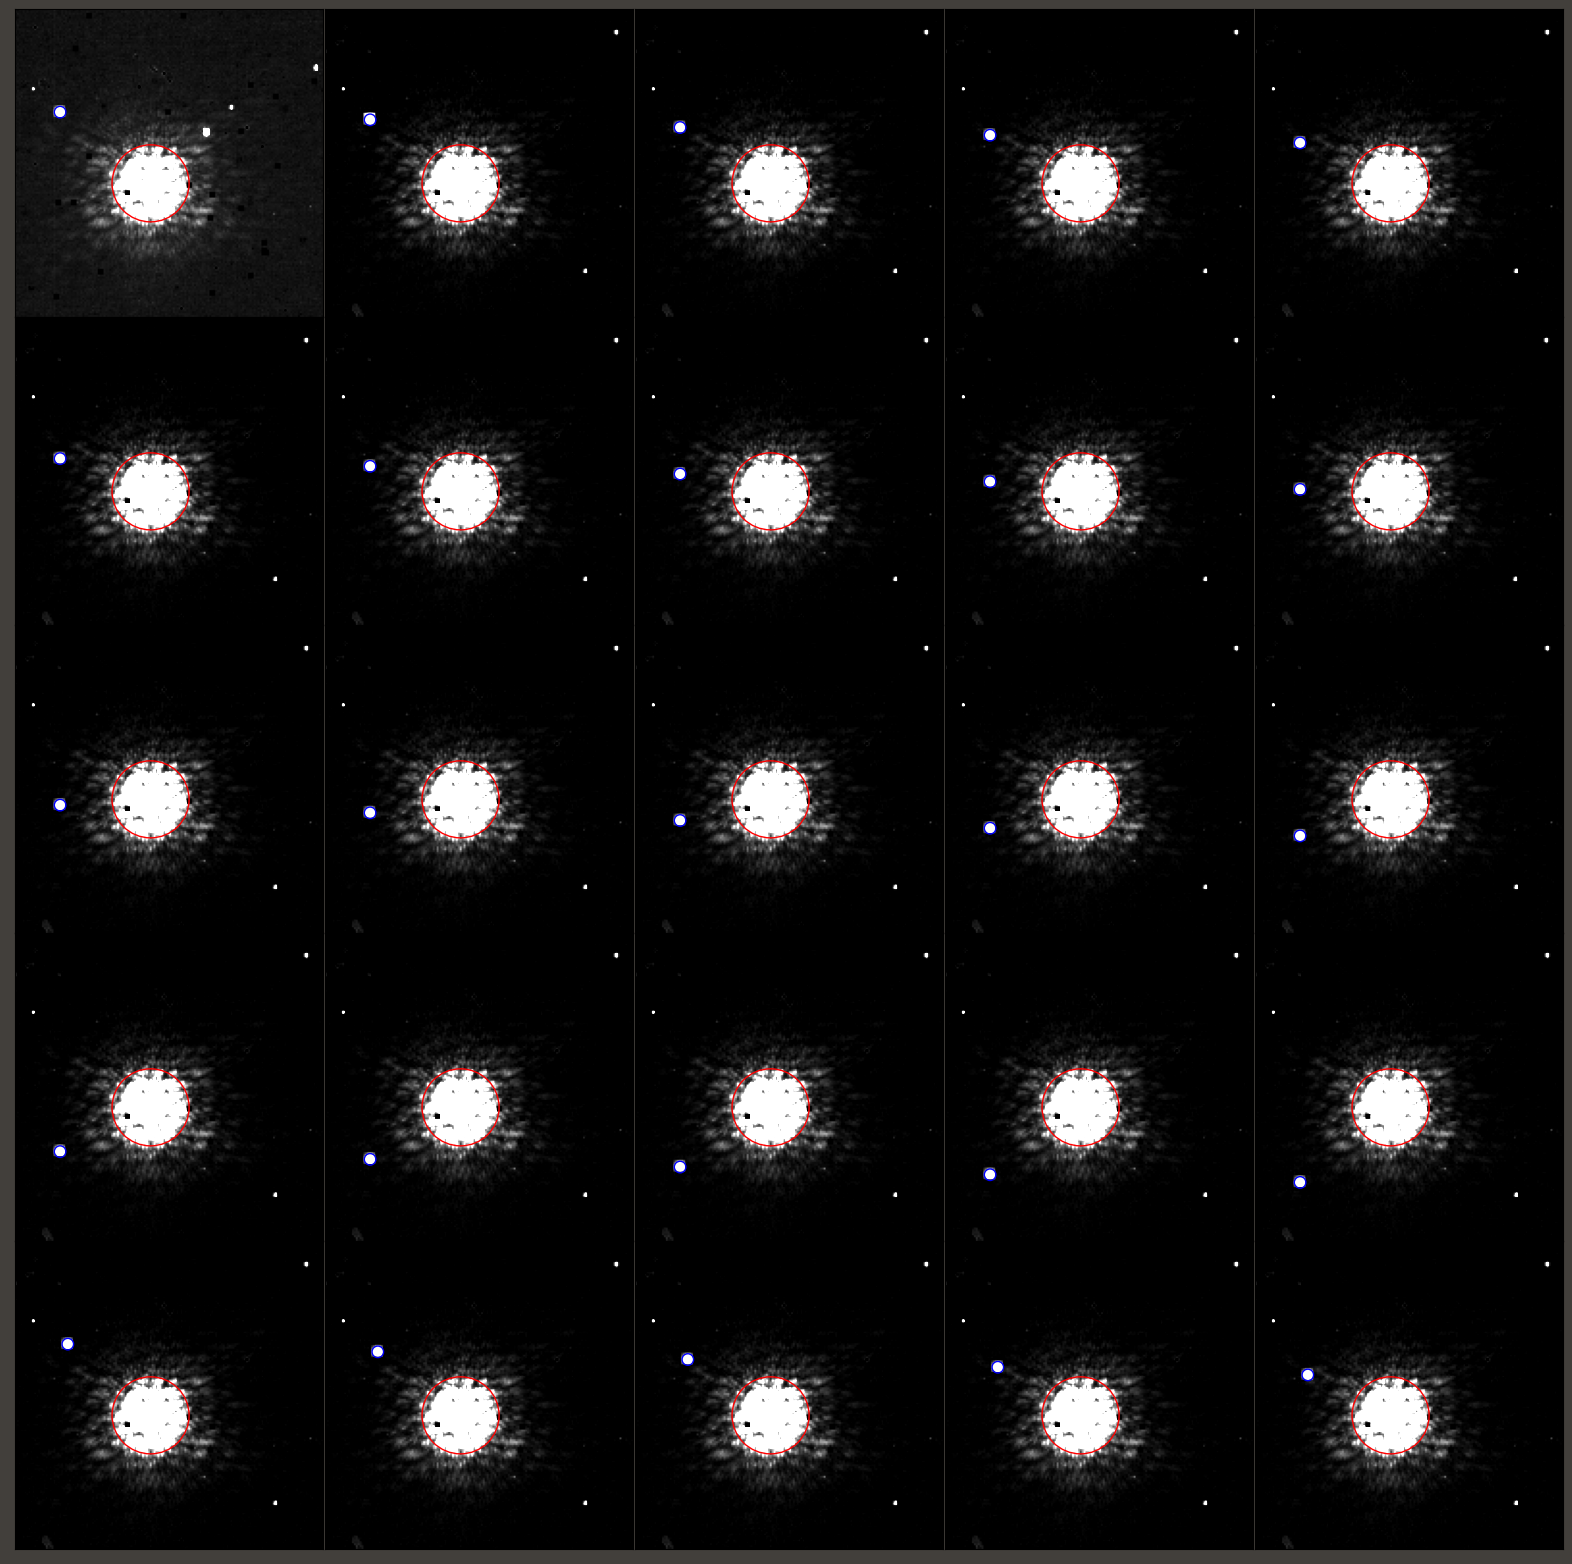

In [24]:
visualize_data(img_stack,new_locs)